Notes:

* implement policy gradient method
* train step after episode
* training in script outside of colab (w/o rendering to save)
* use same arch: https://github.com/mswang12/Blog/blob/master/Completed_2020/REINFORCE_reimplementation/REINFORCE_reimplementation.py


In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

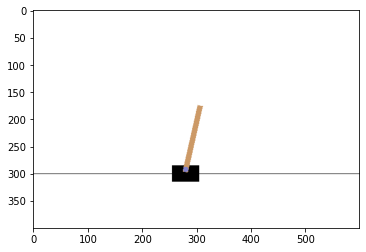

In [3]:
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(1000):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')  # Skip if want to train w/o image

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()

In [4]:
print(obs, reward, action)

[-0.15659019 -0.76654657  0.22219179  1.50925089] 1.0 0


In [20]:
import torch
from torch import nn

class Agent(nn.Module):
    def __init__(self, state_shape, action_shape):
        super(Agent, self).__init__()
        self.state_shape = state_shape
        self.action_shape = action_shape

        self.relu = nn.ReLU(inplace=True)
        self.linear1 = nn.Linear(state_shape, 24)
        self.linear2 = nn.Linear(24, 12)
        self.linear3 = nn.Linear(12, action_shape)
        self.softmax = nn.Softmax()

    def forward(self, state):
        # print(state, state.shape)
        x = self.relu(self.linear1(state))
        x = self.relu(self.linear2(x))
        action = self.softmax(self.linear3(x))
        
        return action

In [31]:
agent = Agent(4, 2)
# agent.double() # Observation is double, so convert agent params to double

In [32]:
print(obs.dtype)
obs_tmp = obs.astype(np.float32)
torch_obs = torch.from_numpy(obs_tmp)
print(agent.forward(torch_obs))

float64
tensor([-0.1566, -0.7665,  0.2222,  1.5093]) torch.Size([4])
tensor([0.4494, 0.5506], grad_fn=<SoftmaxBackward>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
